In [137]:
#Importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
df = pd.read_csv("../input/train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### This notebook is about implementation of Word2vec and so the concern is only questions and finding similarity between words inspired from Liana's kernel.  

In [139]:
#Ths will simply tokenize eg: "what is your name" -> "what", "is", "your", "name".
def read_questions(row,column_name):
    return gensim.utils.simple_preprocess(str(row[column_name]).encode('utf-8'))

In [140]:
documents = []
for index, row in df.iterrows():
    documents.append(read_questions(row,"question1"))
    if row["is_duplicate"] == 0:
        documents.append(read_questions(row,"question2"))

In [141]:
documents[:2]

[['what',
  'is',
  'the',
  'step',
  'by',
  'step',
  'guide',
  'to',
  'invest',
  'in',
  'share',
  'market',
  'in',
  'india'],
 ['what',
  'is',
  'the',
  'step',
  'by',
  'step',
  'guide',
  'to',
  'invest',
  'in',
  'share',
  'market']]

In [142]:
model = gensim.models.Word2Vec(size=150, window=10, min_count=4, sg=1, workers=10)
model.build_vocab(documents)  # prepare the model vocabulary

<b>size</b>: The size means the dimensionality of word vectors. It defines the number of tokens used to represent each word. If a dataset is small, then size should be small too. If a dataset is large, then size should be greater too. It's the question of tuning.

<b>window</b>: The maximum distance between the target word and its neighboring word. Rule-of-thumb: a smaller window should provide terms that are more related.

<b>min_count</b>: Ignores all words with total frequency lower than this. For example, if the word frequency is extremally low, then this word might be considered as unimportant.

<b>sg</b>: Selects training algorithm: 1 for Skip-Gram; 0 for CBOW (Continuous Bag of Words).

<b>workers</b>: The number of worker threads used.

In [143]:
model.train(sentences=documents, total_examples=len(documents), epochs=model.iter)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


(25259285, 35144510)

##### The learned vocabulary of tokens (words) is stored in "model.wv.vocab".

In [144]:
#Unique words
len(word_vectors.vocab)

3068

In [145]:
#This will be 150 as we specified in size of the model
vector = model.wv["modi"]  # numpy vector of a word
len(vector)

150

#### We can now create a two-dimensional semantic representation of word embeddings using t-SNE.

In [146]:
def vocab_size(words):
    wanted_words = []
    count = 0
    for word in word_vectors.vocab:
        if count<words:
            wanted_words.append(word)
            count += 1
        else:
            break
    return dict((k, word_vectors.vocab[k]) for k in wanted_words if k in word_vectors.vocab)

In [147]:
#Number of words to be considered for the plot
wanted_vocab = vocab_size(200)
X = model[wanted_vocab] # X is an array of word vectors, each vector containing 150 tokens
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
Y = tsne_model.fit_transform(X)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


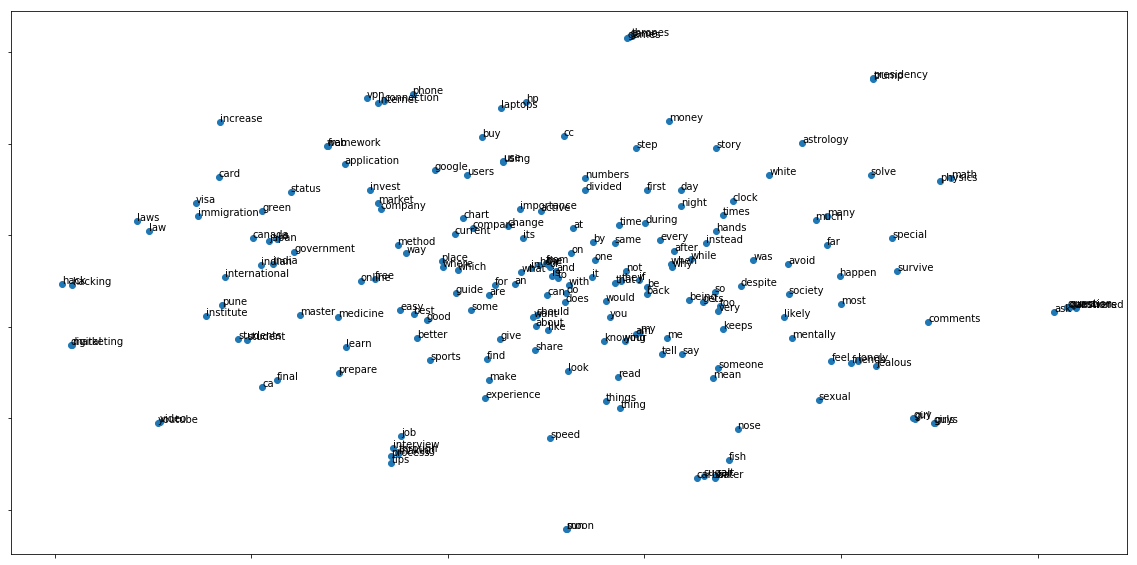

In [148]:
#Plot the t-SNE output
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(Y[:, 0], Y[:, 1])
words = list(wanted_vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(Y[i, 0], Y[i, 1]))
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks
_ = plt.show()

##### We can see all similar words are close to each other. Let us see the results in a tabular format.

In [149]:
w1 = "government"
model.wv.most_similar(positive=w1, topn=10)

[('govt', 0.7328530550003052),
 ('demonetise', 0.6364625692367554),
 ('goverment', 0.6358590126037598),
 ('abolish', 0.6131106615066528),
 ('demolished', 0.6105832457542419),
 ('invalidating', 0.6057320833206177),
 ('pongal', 0.5877999663352966),
 ('upa', 0.5828555822372437),
 ('goi', 0.5809146761894226),
 ('demonitisation', 0.5769199132919312)]

Next, given positive and negative words, we will find top 2 words that are similar to positive words and opposite to negative words.

In [150]:
w1 = ["women","rights"]
w2 = ["girls"]
model.wv.most_similar (positive=w1,negative=w2,topn=2)

[('equality', 0.566362202167511), ('settlements', 0.5540062189102173)]

Finally, I will use Word2Vec to find odd items given a list of items "government","corruption" and "peace". Word2Vec knows 

In [151]:
model.wv.doesnt_match(["government","corruption","peace"])

/opt/conda/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'peace'


## When can we use Word2Vec? <a name="usage"></a>

There are many application scenarios for Word2Vec: sentiment analysis, recommender systems, etc. For example, imagine that you have tags for a large amount of questions in Quora. We can find similar tags. 